# PROJEKT DNO OKA - WERSJA NA 4 
#### Jakub Stefański 151876
#### Filip Rosiak 151799


## Import potrzebnych bibliotek

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from imblearn.metrics import sensitivity_score, specificity_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import pickle
import os

## Ścieżki zawierające analizowane zdjęcia

In [2]:
data_path = "data/"
hand_masks_path = "hand_masks/"

## Zaimplementowane funkcje 

Funkcja preprocess_image() służy do wstępnego przetworzenia obrazu. W pierwszym kroku obraz jest skalowany do mniejszego rozmiaru (1/9 oryginału), aby przyspieszyć przetwarzanie. Nastepnie wybierany jest kanał zielony z obrazu. W kolejnym kroku obraz kolorowy i zielony są filtrowane przy użyciu medianBlur() w celu wstępnego pozbycia się szumów i zakłóceń. Na koniec histogram kanału zielonego jest wyrównywany przy pomocy metody clahe, której użyliśmy zamiast equalizeHist(), który dodawał dużo szumu pokazującego się po zastosowaniu filtru Frangiego.

Funkcja preprocess_mask() służy do przeskalowania ręcznej maski. Oryginalna maska skalowana jest do rozmiaru 1/9 oryginału, a następnie przy pomocy threshold usuwamy odcienie szarości aby piksele maski były jednynie czarne oraz białe.

In [3]:
def preprocess_image(img):
    img = cv2.resize(img, (img.shape[1]//3, img.shape[0]//3))
    green_img = img[:,:,1]
    denoised_green_img = cv2.medianBlur(green_img, 5)
    denoised_img = cv2.medianBlur(img, 5)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    normalized_green_img = clahe.apply(denoised_green_img)

    return green_img, denoised_green_img, normalized_green_img, denoised_img


def preprocess_mask(mask):
    mask = cv2.resize(mask, (mask.shape[1]//3, mask.shape[0]//3))
    
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    return mask

Funkcja extract_features() służy do wyodrębniania cech obrazu przy pomocy wycinków. Wykorzystuje zielony kanał oraz pełen obraz do ekstrakcji cech obrazu takich jak wariancja i średnia kolorów oraz momenty Hu. Do wydobytych cech dodajemy także koordynaty x orazy y, które bedą potrzebne przy tworzeniu zbioru danych do trenowania

In [4]:
def extract_features(green_img, img, window_size=5):
    features = []

    half_window = window_size//2

    for y in range(half_window, img.shape[0] - half_window):
        for x in range(half_window, img.shape[1] - half_window):
            window = img[y-half_window:y+half_window+1, x-half_window:x+half_window+1]
            green_window = green_img[y-half_window:y+half_window+1, x-half_window:x+half_window+1]

            std = np.std(window.reshape(-1, 3), axis=0)
            mean = np.mean(window.reshape(-1, 3), axis=0)

            moments = cv2.moments(green_window)
            hu_moments = cv2.HuMoments(moments).flatten()

            features.append((x, y, np.hstack([std, mean, hu_moments])))
            
    return features

Funkcja create_dataset() ma na celu utworzenie zbioru danych składającego się z cech obrazu oraz zbioru odpowiadającym im etykiet z maski eksperckiej.  

In [5]:
def create_dataset(green_img, img, mask, window_size=5):
    features = extract_features(green_img, img, window_size)

    X = [feat[2] for feat in features]
    y = [mask[feat[1], feat[0]] for feat in features]

    return np.array(X), np.array(y)

Funkcja evaluate_model() ocenia wydajność modelu klasyfikacyjnego na zbiorze testowym, generując raport klasyfikacji oraz macierz pomyłek. 

Funckja compare_masks() porównuje maskę naczyć przewidzaną przez klasyfikator z maską ekspercką. Fukcja obliczna metryki takie jak trafność, czułość, swoistość oraz średnie arytmetyczne oraz geometryczne czułości i swoistości. Wyświetlana jest także macierz pomyłek. 

In [6]:
def evaluate_model(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def compare_masks(original_mask, pred_mask):
    cm = confusion_matrix(original_mask.flatten(), pred_mask.flatten())

    acc = accuracy_score(original_mask.flatten(), pred_mask.flatten())
    sens = sensitivity_score(original_mask.flatten(), pred_mask.flatten(), pos_label=255)
    spec = specificity_score(original_mask.flatten(), pred_mask.flatten(), pos_label=255)

    print("Accuracy: ", acc)
    print("Sensitivity: ", sens)
    print("Specificity: ", spec)
    print("Mean of Sensitivity and Specificity: ", (sens+spec)/2)
    print("Geo mean of Sensitivity and Specificity: ", (sens*spec)**(1.0/2))

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Funkcja train_model() służy do trenowania modelu klasifikacyjnego (w tym przypadku RandomForest) przy pomocy dostarczonych danych treningowych. Funkcja zapisuje równiuesz wytrenowany model na dysk, aby można było go ponownie użyć bez konieczności ponownego trenowania. 
Dla każdego obrazu po jego wstępnych przetworzeniu funkcja ekstrahuje jego cechy przy pomocy funkcji create_dataset() i dodaje je do list features oraz labels. Następnie przy pomocy RandomUnderSampler() balansujemy rozkład klas w danych, po czym dzielimy je na zbiory testowe i treningowe. Wykorzystujemy RandomForestClassifier w połączeniu z GridSearchCV, w celu znalezienia najlepszych hiperparametrów. Nastepnie najlepszy znaleziony model ewaluowany jest w funkcji evaluate_model(). 

In [7]:
def train_model(train_data, model_path="classifier.pkl"):
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            best_clf = pickle.load(f)
        print("Model loaded from disk.")
        return best_clf

    features = []
    labels = []

    for file in train_data:
        img = cv2.imread(data_path+file)
        mask_name = file[:-3]+"tif"
        mask = cv2.imread(hand_masks_path+mask_name, 0)

        _, _, normalized_green_img, denoised_img = preprocess_image(img)
        processed_mask = preprocess_mask(mask)

        X, y = create_dataset(normalized_green_img, denoised_img, processed_mask)

        features.extend(X)
        labels.extend(y)

    print("Done preparing data")
    
    rus = RandomUnderSampler(random_state=10)
    X_res, y_res = rus.fit_resample(features, labels)
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=10)

    print("Done train test split")

    clf = RandomForestClassifier(random_state=10)

    # searched params
    # param_grid = {
    #     'n_estimators': [200, 500, 1000],
    #     'max_depth': [None, 10, 30, 50],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4]
    # }

    # best params
    param_grid = {
        'n_estimators': [1000],
        'max_depth': [50],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'n_jobs': [-1]
    }

    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print(grid_search.best_params_)

    best_clf = grid_search.best_estimator_

    evaluate_model(best_clf, X_test, y_test)

    with open(model_path, 'wb') as f:
        pickle.dump(best_clf, f)
    print("Model trained and saved to disk.")

    return best_clf

Funkcja predict_vessels() służy do tworzenia maski naczyń krwionośnych z obrazu przy użyciu wytrenowanego modelu klasyfikacyjnego. Po wstępnych przetworzeniu obrazu, ekstrahowane są jego cechy na podstawie których tworzymy maskę predykcyjną. 

In [8]:
def predict_vessels(clf, file):
    img = cv2.imread(data_path+file)
    _, _, normalized_green_img, denoised_img = preprocess_image(img)
    
    features = extract_features(normalized_green_img, denoised_img)
    X_full = [feat[2] for feat in features]

    predictions = clf.predict(X_full)

    prediction_mask = np.zeros_like(normalized_green_img, dtype=np.uint8)

    for i, (x, y, _) in enumerate(features):
        prediction_mask[y, x] = predictions[i]

    return prediction_mask, predictions

## Wywołanie funkcji

Poniższy kod wywołuje wcześniejsze funkcje. 

Model loaded from disk.
11_h.jpg
Accuracy:  0.923577974786069
Sensitivity:  0.8213529162547663
Specificity:  0.934122991458387
Mean of Sensitivity and Specificity:  0.8777379538565766
Geo mean of Sensitivity and Specificity:  0.8759250214344674


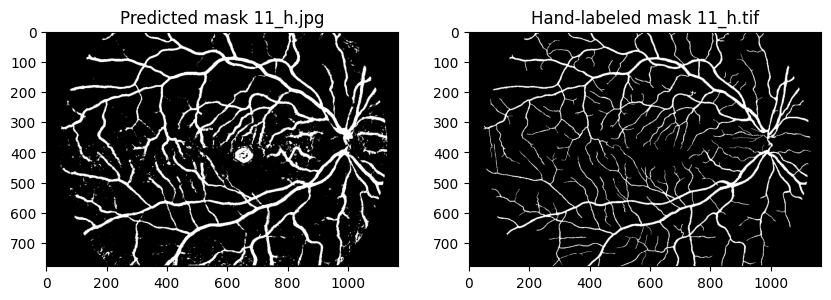

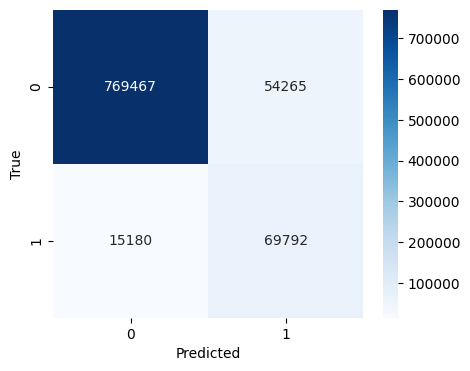

12_h.jpg
Accuracy:  0.9231542944677255
Sensitivity:  0.8239901028506725
Specificity:  0.934783597660462
Mean of Sensitivity and Specificity:  0.8793868502555673
Geo mean of Sensitivity and Specificity:  0.8776402638777268


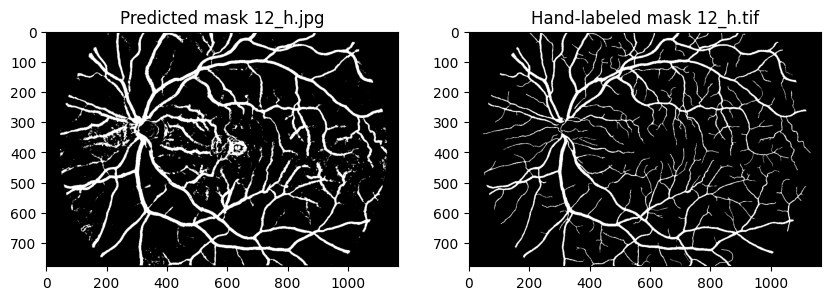

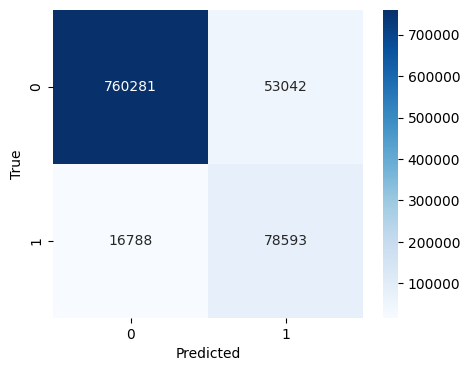

13_h.jpg
Accuracy:  0.8947710145437898
Sensitivity:  0.8429014494588265
Specificity:  0.8997094161929062
Mean of Sensitivity and Specificity:  0.8713054328258664
Geo mean of Sensitivity and Specificity:  0.8708423341803929


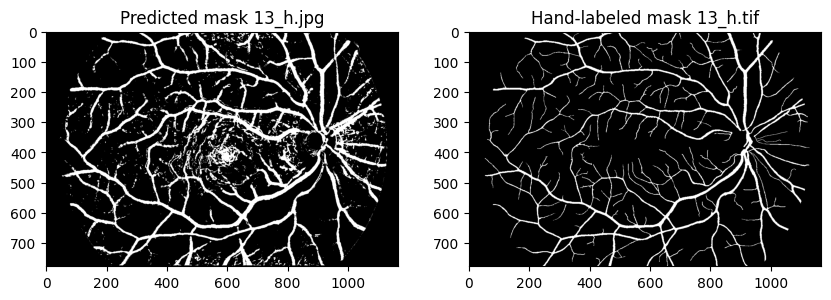

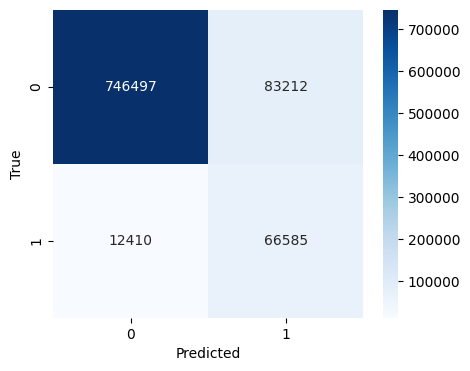

14_h.jpg
Accuracy:  0.9001181903017924
Sensitivity:  0.8026597756208244
Specificity:  0.9094401319549443
Mean of Sensitivity and Specificity:  0.8560499537878843
Geo mean of Sensitivity and Specificity:  0.8543834105690071


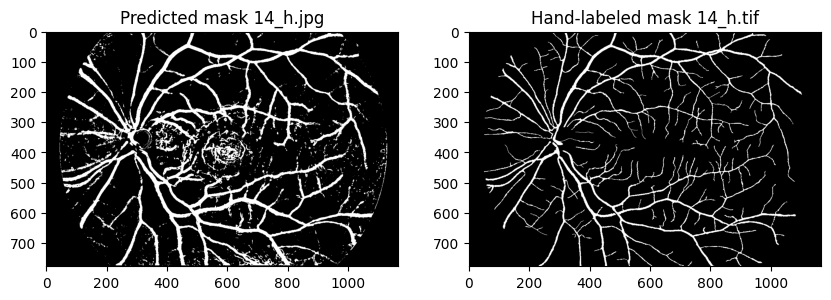

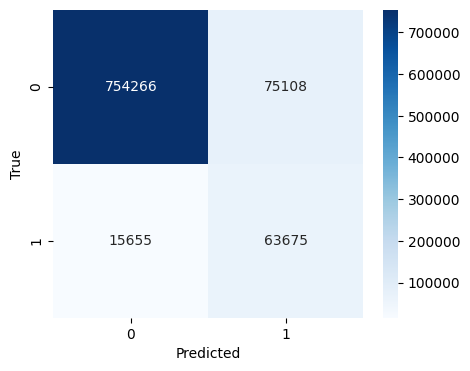

15_h.jpg
Accuracy:  0.9293202186850724
Sensitivity:  0.7030175438596491
Specificity:  0.9485738918197298
Mean of Sensitivity and Specificity:  0.8257957178396895
Geo mean of Sensitivity and Specificity:  0.816617467114496


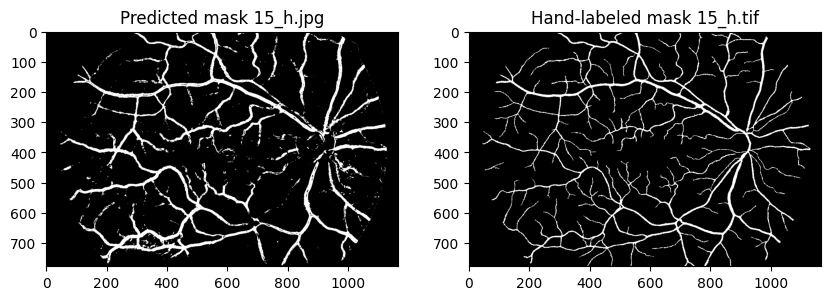

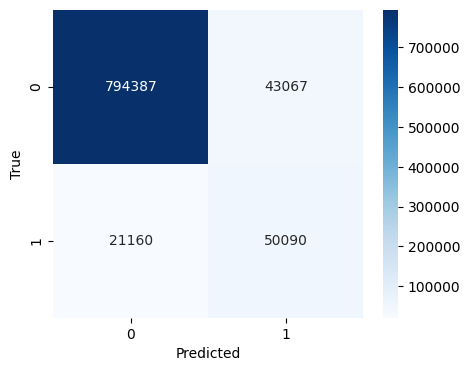

In [9]:
train_data = ["01_h.jpg", "02_h.jpg", "03_h.jpg", "04_h.jpg", "05_h.jpg", "06_h.jpg", "07_h.jpg"]
clf = train_model(train_data=train_data)

test_data = ["11_h.jpg", "12_h.jpg", "13_h.jpg", "14_h.jpg", "15_h.jpg"]
for file in test_data:
    print(file)
    
    our_mask, predictions = predict_vessels(clf, file)

    fig = plt.figure(figsize=(10,10))

    fig.add_subplot(121)
    plt.title(f"Predicted mask {file}")
    plt.imshow(our_mask, cmap="gray")

    mask_name = file[:-3]+"tif"
    mask = cv2.imread(hand_masks_path+mask_name, 0)
    mask = preprocess_mask(mask)

    fig.add_subplot(122)
    plt.title(f"Hand-labeled mask {mask_name}")
    plt.imshow(mask, cmap="gray")

    compare_masks(mask, our_mask)